In [50]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.metrics import mean_squared_error

import xgboost as xgb

import matplotlib.pyplot as plt 

%matplotlib inline


In [3]:
df = pd.read_csv("housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
useful_cols = ['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population',
    'households','median_income','median_house_value','ocean_proximity']
df = df[useful_cols]    

In [5]:
df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [6]:
df.fillna(0, inplace=True )
df.isnull().sum()

latitude              0
longitude             0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [7]:
df.median_house_value = np.log1p(df.median_house_value)

In [9]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [10]:
df_train.shape, df_val.shape, df_test.shape

((12384, 10), (4128, 10), (4128, 10))

In [11]:
y_full_train = df_full_train.median_house_value.values
y_train = df_train.median_house_value.values 
y_val = df_val.median_house_value.values 
y_test = df_test.median_house_value.values 

df_full_train.drop("median_house_value", axis=1, inplace=True)
df_train.drop("median_house_value", axis=1, inplace=True)
df_val.drop("median_house_value", axis=1, inplace=True)
df_test.drop("median_house_value", axis=1, inplace=True)

## Question 1

In [18]:
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient="records")
X_train = dv.fit_transform(train_dict)

In [19]:
dt = DecisionTreeRegressor(max_depth=1)

In [20]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [22]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



c:\Users\emekadavid\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Question 2

In [30]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

In [31]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [32]:
val_dict = df_val.to_dict(orient="records")
X_val = dv.transform(val_dict)

In [33]:
y_prediction = rf.predict(X_val)

In [36]:
rmse = np.sqrt(mean_squared_error(y_val, y_prediction))
rmse

0.24545397046300327

## Question 3

In [37]:
number_estimators = np.arange(10, 201, 10)
values = []

for n in number_estimators:
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred)) 
    values.append((n, rmse))
     


In [39]:
df_values = pd.DataFrame(values, columns=["n_estimators", "rmse"])

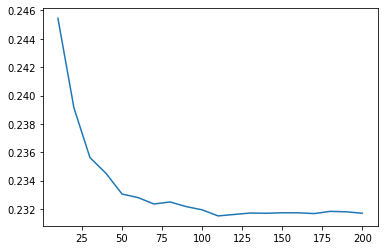

In [43]:
plt.plot(df_values.n_estimators, df_values.rmse)
#plt.ylim(0, 0.23)

## Question 4

In [44]:
number_estimators = np.arange(10, 201, 10)
values = []
depths = [10, 15, 20, 25]

for depth in depths:    
    for n in number_estimators:
        rf = RandomForestRegressor(n_estimators=n, random_state=1, max_depth=depth)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred)) 
        values.append((depth, n, rmse))
     


In [46]:
df_depth = pd.DataFrame(values, columns=["max_depth", "n_estimators", "rmse"])
df_depth.sort_values(by="rmse")

,max_depth,n_estimators,rmse
70,25,110,0.231275
71,25,120,0.231316
76,25,170,0.231458
73,25,140,0.231477
79,25,200,0.231493
...,...,...,...
4,10,50,0.250192
3,10,40,0.251062
2,10,30,0.251647
1,10,20,0.252784


## Question 5

In [47]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [49]:
feature_values = pd.Series(rf.feature_importances_, index=dv.feature_names_).sort_values(ascending=False)
feature_values

median_income                 0.363080
ocean_proximity=INLAND        0.310901
latitude                      0.101310
longitude                     0.096312
housing_median_age            0.033105
population                    0.030960
total_rooms                   0.020512
total_bedrooms                0.018634
households                    0.017169
ocean_proximity=NEAR OCEAN    0.004243
ocean_proximity=<1H OCEAN     0.002988
ocean_proximity=NEAR BAY      0.000429
ocean_proximity=ISLAND        0.000357
dtype: float64

## Question 6

In [56]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [82]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [83]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [85]:
y_pred = model.predict(dval)

In [86]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

0.2260957847928297